In [337]:
import torch
from torch import nn
import numpy as np
import pandas
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (10,6)

pandas.set_option('precision', 20)

In [86]:
class Network(nn.Module):
        def __init__(self):
                super().__init__()

                # Layer sizes
                self.input = nn.Linear(6, 50)
                self.first_hidden = nn.Linear(50, 100)
                self.second_hidden = nn.Linear(100, 250)
                self.third_hidden = nn.Linear(250, 250)
                self.fourth_hidden = nn.Linear(250, 100)
                self.fifth_hidden = nn.Linear(100, 50)
                self.output = nn.Linear(50, 1)

                # Activation functions
                self.relu = nn.ReLU()
                self.sigmoid = nn.Sigmoid()

        def forward(self, x:[])->[]:
                x = self.input(x)
                x = self.relu(x)
                x = self.first_hidden(x)
                x = self.relu(x)
                x = self.second_hidden(x)
                x = self.relu(x)
                x = self.third_hidden(x)
                x = self.relu(x)
                x = self.fourth_hidden(x)
                x = self.relu(x)
                x = self.fifth_hidden(x)
                x = self.relu(x)            
                x = self.output(x)

                return x

In [347]:
def get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength, mode)->torch.tensor:
    wavelengths = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)
    
    fill_factor = (fill_factor - dataframe.min()['Fill Factor'])/\
    (dataframe.max()['Fill Factor'] - dataframe.min()['Fill Factor'])
    
    pitch = (pitch - dataframe.min()['Pitch'])/(dataframe.max()['Pitch'] - dataframe.min()['Pitch'])
    
    theta = (theta - dataframe.min()['Theta'])/(dataframe.max()['Theta'] - dataframe.min()['Theta'])
    
    duty_cycle = (duty_cycle - dataframe.min()['Duty Cycle'])/(dataframe.max()['Duty Cycle'] - dataframe.min()['Duty Cycle'])
    
    wavelength = (wavelength - min(wavelengths))/(max(wavelengths) - min(wavelengths))
    
    return torch.tensor([theta, pitch, duty_cycle, fill_factor, wavelength, mode], dtype=torch.float32)

def get_transmission_val(nn_val)->float:
    return np.power(10, nn_val.detach().numpy())

***Load in the Grating Coupler Model***

In [382]:
GratingCouplerNet = torch.load('DATA_FILES/GratingCouplerNetModel').eval()

In [354]:
dataframe = pandas.read_csv('DATA_FILES/dataset_new.csv')
training_statistics = pandas.read_csv('DATA_FILES/training_stats.csv')
dusan_paper_TM = pandas.read_csv('TEST_SIMULATIONS/Dusans_Plot_TM_mode.txt')
dusan_paper_TE = pandas.read_csv('TEST_SIMULATIONS/Dusans_Plot_TE_mode.txt')
test_TM = pandas.read_csv('TEST_SIMULATIONS/Testing_TM.txt')
test_TE = pandas.read_csv('TEST_SIMULATIONS/Testing_TE.txt')
test_TM2 = pandas.read_csv('TEST_SIMULATIONS/Testing_TM_2.txt')
test_TE2 = pandas.read_csv('TEST_SIMULATIONS/Testing_TE_2.txt')
test_TM3 = pandas.read_csv('TEST_SIMULATIONS/Testing_TM_3.txt')
test_TE3 = pandas.read_csv('TEST_SIMULATIONS/Testing_TE_3.txt')

***Looking at the learning and testing losses ...***

From the figure below we can see that the testing loss follows the learning loss ...


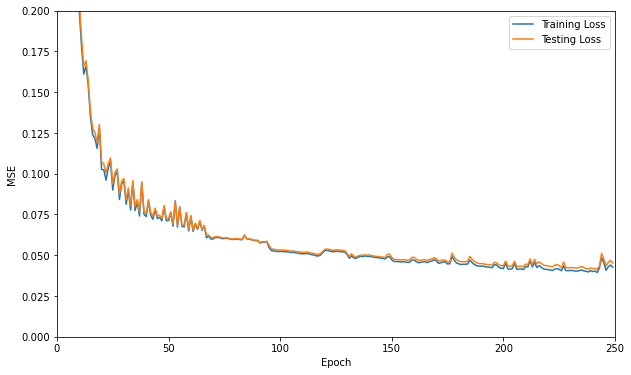

In [375]:
plt.plot(training_statistics['training_loss'], label='Training Loss')
plt.plot(training_statistics['testing_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.axis([0, 250, 0, 0.2])
plt.legend()

***Looking at the learning rate over the epochs ...***

For this training I chose to keep the learning rate constant over the training cycle

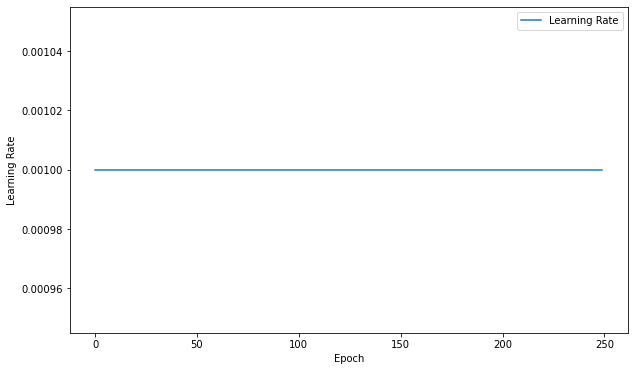

In [342]:
plt.plot(training_statistics['learning_rate'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

***COMPARING TO DUSAN'S PAPER***

In [367]:
# Comparison to Dusan Paper
theta = (14.375)
pitch = (0.75*10**(-6))
duty_cycle = (0.65)
fill_factor = (0.25)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, GratingCouplerNet(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, GratingCouplerNet(x).detach().numpy())

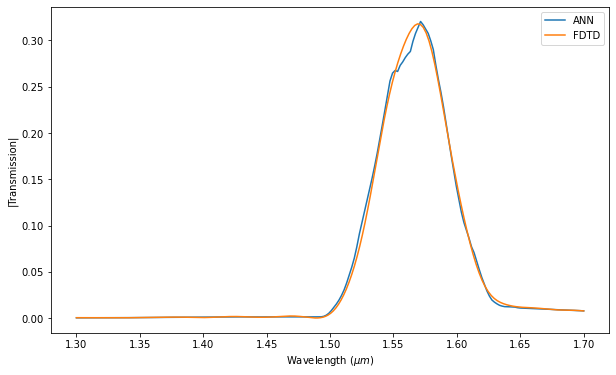

In [368]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.plot(np.flip(dusan_paper_TM['X'])/10**(-6), np.abs(np.flip(dusan_paper_TM['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

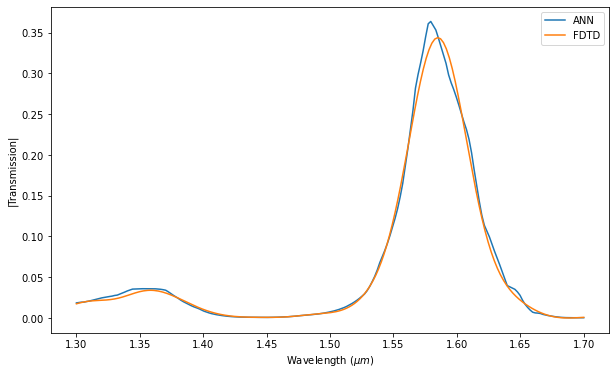

In [369]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(dusan_paper_TE['X'])/10**(-6), np.abs(np.flip(dusan_paper_TE['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

***TESTING OUT OPTIMIZING PARAMETERS AT $\lambda=1.55\ \mu m$***

In [383]:
thetas = np.linspace(dataframe.min()['Theta'], dataframe.max()['Theta'], 10)
pitchs = np.linspace(dataframe.min()['Pitch'], dataframe.max()['Pitch'], 10)
duty_cycles = np.linspace(dataframe.min()['Duty Cycle'], dataframe.max()['Duty Cycle'], 10)
fill_factors = np.linspace(dataframe.min()['Fill Factor'], dataframe.max()['Fill Factor'], 10)
mode = 0
wavelength = 1.55*10**(-6)

In [384]:
max_val = 0;
params = [0, 0, 0, 0]
mode = 0
count = 1

for theta in thetas:
    for pitch in pitchs:
        for duty_cycle in duty_cycles:
            for fill_factor in fill_factors:
                x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength, mode)
                if max_val < get_transmission_val(GratingCouplerNet(x)):
                    max_val = get_transmission_val(GratingCouplerNet(x))
                    params[0] = theta
                    params[1] = pitch
                    params[2] = duty_cycle
                    params[3] = fill_factor
                count = count + 1
print(params, max_val)

[16.666666666666668, 7.222222222222222e-07, 0.5777777777777778, 0.24444444444444446] [0.41061237]


***COMPARISON TO OPTIMIZED DATA***

In [370]:
theta = (10)
pitch = (1.5*10**(-6))
duty_cycle = (0.4444444444444445)
fill_factor = (0.5555555555555556)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, GratingCouplerNet(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, GratingCouplerNet(x).detach().numpy())

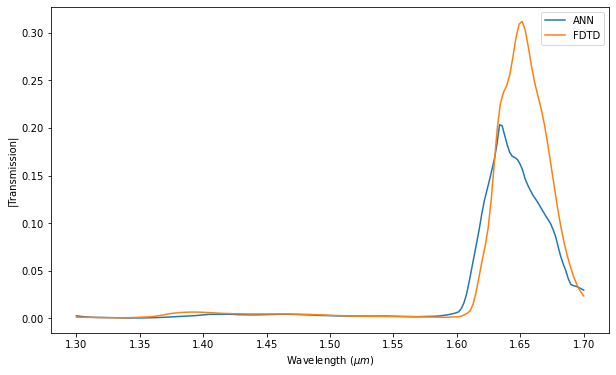

In [372]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.plot(np.flip(test_TM['X'])/10**(-6), np.abs(np.flip(test_TM['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

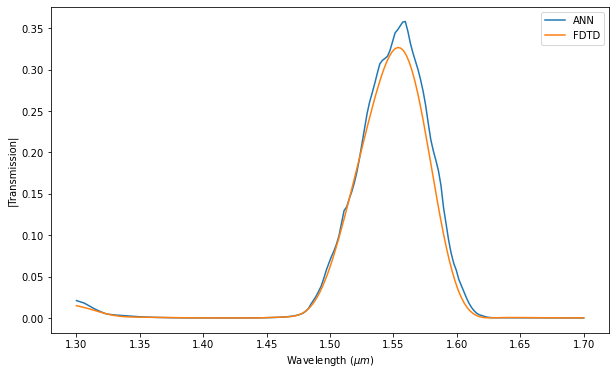

In [373]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(test_TE['X'])/10**(-6), np.abs(np.flip(test_TE['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

In [376]:
theta = (8.5)
pitch = (0.886*10**(-6))
duty_cycle = (0.8)
fill_factor = (0.6)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, GratingCouplerNet(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, GratingCouplerNet(x).detach().numpy())

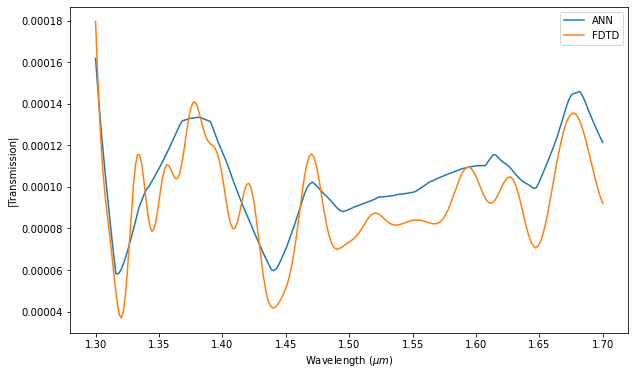

In [378]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.plot(np.flip(test_TM2['X'])/10**(-6), np.abs(np.flip(test_TM2['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

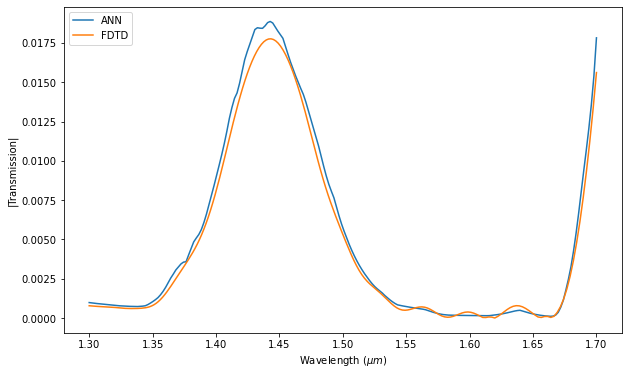

In [379]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(test_TE2['X'])/10**(-6), np.abs(np.flip(test_TE2['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()